Questions pos√©es :
- Mesurer l'impact du COVID sur le trafic de mani√®re globale et locale.
- Y-a-t-il des facteurs d√©mographiques qui sont correlable avec le trafic ?
- Peut-on cr√©er un mod√®le viable d'estimation du trafic √† partir de quelques facteurs d√©mographiques ?

# Premi√®re exploration et nettoyage de la donn√©e ouverte de la RATP

>Tout d'abord, j'importe les librairies utiles au projet :

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

> J'importe le dataset par ann√©e:



In [ ]:
data_set_par_annee={"2013":"","2014":"","2015":"","2016":"","2017":"","2018":"","2019":"","2020":"","2021":""}

for annee in range(2013,2022) :
  data_set_par_annee[annee]=pd.read_csv("trafic-annuel-entrant-par-station-du-reseau-ferre-"+str(annee)+".csv", sep = ";")

#Le dataset de 2016 poss√®de des colonnes en trop
data_set_par_annee[2016] = data_set_par_annee[2016].drop(columns=["Column 12","Column 13","Column 14","Column 15"], axis=1)

for annee in range(2013,2022) :
  data_set_par_annee[annee].loc[data_set_par_annee[annee]['Station'] == 'SAINT-MICHEL-NOTRE-DAME', 'Arrondissement pour Paris'] = 5
  data_set_par_annee[annee].loc[data_set_par_annee[annee]['Ville'] == 'Asni√®res', 'Ville'] = "Asni√®res sur Seine"
  data_set_par_annee[annee].loc[data_set_par_annee[annee]['Ville'] == 'Neuilly Sur Seine', 'Ville'] = "Neuilly-sur-Seine"
  data_set_par_annee[annee].loc[data_set_par_annee[annee]['Ville'] == 'Saint Ouen', 'Ville'] = "Saint-ouen"
  data_set_par_annee[annee].loc[data_set_par_annee[annee]['Ville'] == 'Maisons -Alfort', 'Ville'] = "Maisons-Alfort"
  data_set_par_annee[annee].loc[data_set_par_annee[annee]['Ville'] == 'Saint Denis / Aubervilliers', 'Ville'] = "Saint Denis"


ATTENTION : apr√®s v√©rification, il y a plusieurs probl√®mes sur ces datasets : 
- Le dataset de 2016 poss√®de 4 colonnes en trop avec aucune donn√©e
- Le dataset de 2014 ne poss√®de pas d'arrondisement pour une dizaine de stations parisiennes (j'ai modifi√© dirrectement le document en question)
- Tous les datasets n'ont pas d'arrondisement indiqu√© pour la station de Saint-Michel-Notre-Dame
- Certaines villes ne sont pas √©crites de mani√®re identique (par exemple Asni√®res/Asni√®res sur Seine, Neuilly-sur-Seine/Neuilly Sur Seine, Saint Ouen/Saint-ouen)

Je vais opp√©rer une derni√®re modification (mais qui n'est pas une erreurs dans le dataset), je place la station FRONT POPULAIRE qui est √† Saint Denis / Aubervilliers seulement √† Saint Denis (cela me permet d'avoir une unicit√© sur le champs ville)





> V√©rification des modifications (je montre ici seulement pour 2014 pour all√©ger) :



In [ ]:
print(data_set_par_annee[2014][data_set_par_annee[2014]['Station'] == 'SAINT-MICHEL-NOTRE-DAME']['Arrondissement pour Paris'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Asni√®res']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Asni√®res sur Seine']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Neuilly Sur Seine']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Neuilly-sur-Seine']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Saint Ouen']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Saint-ouen']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Maisons -Alfort']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Maisons-Alfort']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Saint Denis / Aubervilliers']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Saint Denis']['Ville'])

print(data_set_par_annee[2016].columns)

239    5.0
Name: Arrondissement pour Paris, dtype: float64
Series([], Name: Ville, dtype: object)
53     Asni√®res sur Seine
90     Asni√®res sur Seine
221    Asni√®res sur Seine
Name: Ville, dtype: object
Series([], Name: Ville, dtype: object)
4      Neuilly-sur-Seine
5      Neuilly-sur-Seine
250    Neuilly-sur-Seine
Name: Ville, dtype: object
Series([], Name: Ville, dtype: object)
16    Saint-ouen
83    Saint-ouen
Name: Ville, dtype: object
Series([], Name: Ville, dtype: object)
328    Maisons-Alfort
346    Maisons-Alfort
349    Maisons-Alfort
Name: Ville, dtype: object
Series([], Name: Ville, dtype: object)
36     Saint Denis
68     Saint Denis
75     Saint Denis
134    Saint Denis
355    Saint Denis
Name: Ville, dtype: object
Index(['Rang', 'R√©seau', 'Station', 'Trafic', 'Correspondance_1',
       'Correspondance_2', 'Correspondance_3', 'Correspondance_4',
       'Correspondance_5', 'Ville', 'Arrondissement pour Paris'],
      dtype='object')


Voici nos donn√©es corrig√©es :

In [ ]:
print(data_set_par_annee[2021].head())
print(data_set_par_annee[2021].dtypes)

   Rang R√©seau               Station    Trafic Correspondance_1  \
0     3  M√©tro          GARE DE LYON  28640475                1   
1    12  M√©tro            BELLEVILLE   7314438                2   
2    32  M√©tro                 OPERA   5193831                3   
3    58  M√©tro  SAINT-MANDE-TOURELLE   3944640                1   
4    59  M√©tro                 HOCHE   3928404                5   

  Correspondance_2 Correspondance_3  Correspondance_4  Correspondance_5  \
0               14                A               NaN               NaN   
1               11              NaN               NaN               NaN   
2                7                8               NaN               NaN   
3              NaN              NaN               NaN               NaN   
4              NaN              NaN               NaN               NaN   

         Ville  Arrondissement pour Paris  
0        Paris                       12.0  
1        Paris                       10.0  
2       

Maintenant pour √©viter les valeurs nul dans mon dataset je vais basculer les informations de correspondances par des bool√©ens avec une colonne pour chaque ligne.

Je souhaite aussi compter le nombre de correspondances par station.

Je pourrais ensuite supprimer du tableau mes colonnes correspondances.

In [ ]:
liste_ligne= ["A","B","1","2","3","3bis","4","5","6","7","7bis","8","9","10","11","12","13","14"]
for annee in range(2013,2022) :
  for ligne in liste_ligne:
    data_set_par_annee[annee][ligne] = False
    for station_id in range(len(data_set_par_annee[annee])):
      if data_set_par_annee[annee]['Correspondance_1'][station_id]==ligne or data_set_par_annee[annee]['Correspondance_2'][station_id]==ligne or data_set_par_annee[annee]['Correspondance_3'][station_id]==ligne or data_set_par_annee[annee]['Correspondance_4'][station_id]==ligne or data_set_par_annee[annee]['Correspondance_5'][station_id]==ligne :
        data_set_par_annee[annee].loc[station_id,ligne]=True

In [ ]:
for annee in range(2013,2022) :
  data_set_par_annee[annee]["nb_correspondances"]=0
  for station_id in range(len(data_set_par_annee[annee])):
    for i in range(1,6) :
      if data_set_par_annee[annee]['Correspondance_'+str(i)][station_id] in liste_ligne :
        data_set_par_annee[annee].loc[station_id, "nb_correspondances"] += 1

In [ ]:
for annee in range(2013,2022) :
  for i in range(1,6):
    del data_set_par_annee[annee]['Correspondance_'+str(i)]

Je rajoute pour chaque dataset une colonne ann√©e me permettant de les fusionner dans le futur sans perdre cette information

In [ ]:
for annee in range(2013,2022) :
  data_set_par_annee[annee]["Ann√©e"]=annee

Je peux maintenant v√©rifier les nouvelles donn√©es ainsi cr√©√©es :

In [ ]:
print(data_set_par_annee[2021].head())
print(data_set_par_annee[2021].dtypes)

   Rang R√©seau               Station    Trafic        Ville  \
0     3  M√©tro          GARE DE LYON  28640475        Paris   
1    12  M√©tro            BELLEVILLE   7314438        Paris   
2    32  M√©tro                 OPERA   5193831        Paris   
3    58  M√©tro  SAINT-MANDE-TOURELLE   3944640  Saint Mand√©   
4    59  M√©tro                 HOCHE   3928404       Pantin   

   Arrondissement pour Paris      A      B      1      2  ...   7bis      8  \
0                       12.0   True  False   True  False  ...  False  False   
1                       10.0  False  False  False   True  ...  False  False   
2                        9.0  False  False  False  False  ...  False   True   
3                        NaN  False  False   True  False  ...  False  False   
4                        NaN  False  False  False  False  ...  False  False   

       9     10     11     12     13     14  nb_correspondances  Ann√©e  
0  False  False  False  False  False   True                   3  

Remarque : Le type float pour les arrondissements est li√© au "NaN" utilis√© pour les stations n'√©tant pas dans Paris

# Premi√®res analyses et observations

Essayons d'explorer un peu ces premi√®res donn√©es :

In [ ]:
# Initialisation de la liste des dataframes √† concat√©ner
df_list = []

# Ajout de chaque dataframe √† la liste
for annee in range(2013, 2022):
    df_list.append(data_set_par_annee[annee])

# Concat√©nation des dataframes
dataset_complet = pd.concat(df_list, axis=0)

In [ ]:
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

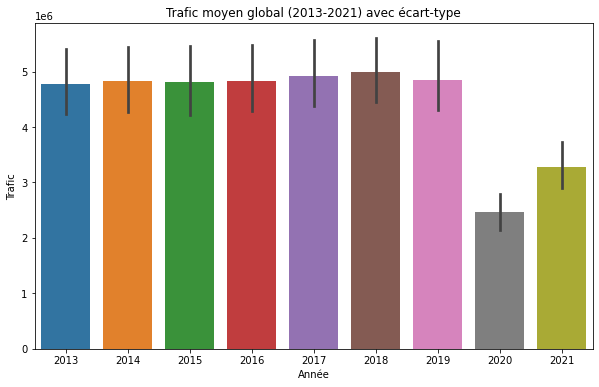

In [ ]:
plt.figure(figsize=(10,6))
df_plot = dataset_complet[['Ann√©e', 'Trafic']]
sns.barplot(x='Ann√©e', y='Trafic', data=df_plot)
plt.title("Trafic moyen global (2013-2021) avec √©cart-type")
plt.show()

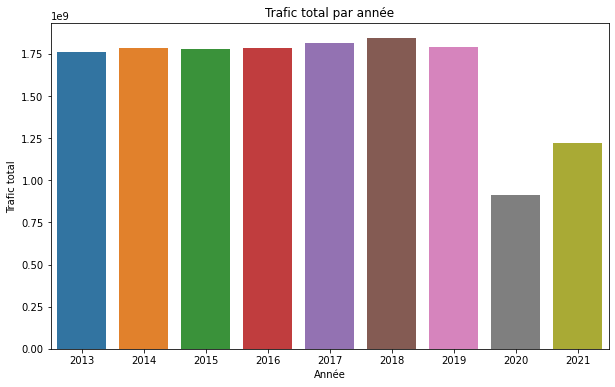

In [ ]:
# Cr√©ation du dataframe √† partir des donn√©es totales par ann√©e
df_trafic_total = pd.DataFrame({'Ann√©e': list(range(2013,2022)), 'Trafic total': [data_set_par_annee[annee]['Trafic'].sum() for annee in range(2013,2022)]})

# Affichage du graphique √† barres
plt.figure(figsize=(10,6))
sns.barplot(x='Ann√©e', y='Trafic total', data=df_trafic_total)
plt.title("Trafic total par ann√©e")
plt.show()

On remarque d√©j√† l'effet fort du Covid sur les ann√©es 2020 et 2021. Je d√©cide donc de les retirer de mes futurs graphiques globaux pour moins fausser la moyenne et l'√©cart type (me permettant de comparer ces tendances globales aux ann√©ees 2020-2021)

In [ ]:
# Initialisation de la liste des dataframes √† concat√©ner
df_list = []

# Ajout de chaque dataframe √† la liste
for annee in range(2013, 2020):
    df_list.append(data_set_par_annee[annee])

# Concat√©nation des dataframes
dataset_hors_covid = pd.concat(df_list, axis=0)

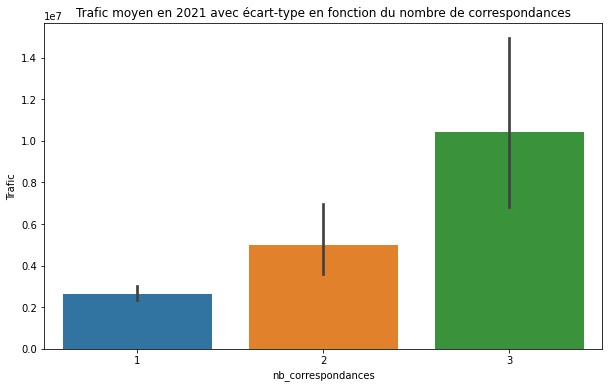

In [ ]:
plt.figure(figsize=(10,6))
df_plot = data_set_par_annee[2021][['nb_correspondances', 'Trafic']]
sns.barplot(x='nb_correspondances', y='Trafic', data=df_plot)
plt.title("Trafic moyen en 2021 avec √©cart-type en fonction du nombre de correspondances")
plt.show()

On remarque, de mani√®re logique, que le nombre de correspondance influe fortement sur le trafic moyen d'une station.

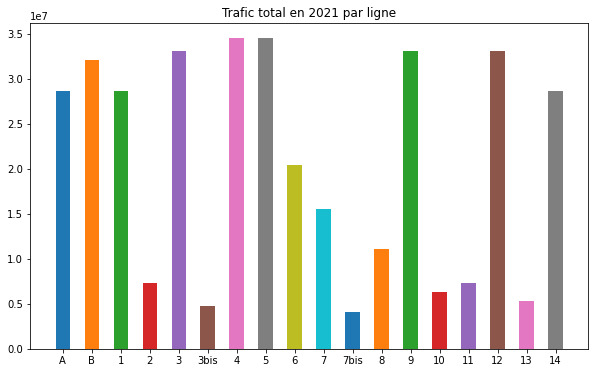

In [ ]:
df_plot = data_set_par_annee[2021][liste_ligne + ['Trafic']]

plt.figure(figsize=(10,6))
x_values = list(range(len(liste_ligne)))

for i, x in enumerate(x_values):
    plt.bar(x, df_plot[df_plot[liste_ligne[i]] != False]['Trafic'], width=0.5)
plt.xticks(x_values, liste_ligne)
plt.title("Trafic total en 2021 par ligne")
plt.show()

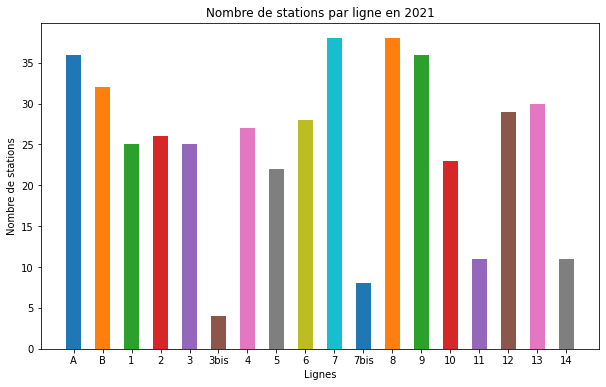

In [ ]:
df_plot = data_set_par_annee[2021][liste_ligne]

plt.figure(figsize=(10,6))
x_values = list(range(len(liste_ligne)))

for i, x in enumerate(x_values):
    y = df_plot[df_plot[liste_ligne[i]] != False].shape[0]
    plt.bar(x, y, width=0.5)
plt.xticks(x_values, liste_ligne)
plt.xlabel("Lignes")
plt.ylabel("Nombre de stations")
plt.title("Nombre de stations par ligne en 2021")
plt.show()

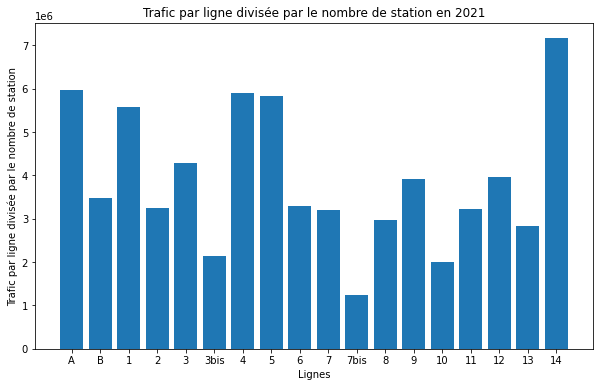

In [ ]:
df_plot = data_set_par_annee[2021][liste_ligne + ['Trafic']]

trafic_par_station = {}

for ligne in liste_ligne:
    nb_stations = len(df_plot[df_plot[ligne] != False])
    trafic_total = df_plot[df_plot[ligne] != False]['Trafic'].sum()
    trafic_par_station[ligne] = trafic_total / nb_stations

plt.figure(figsize=(10,6))
plt.bar(trafic_par_station.keys(), trafic_par_station.values())
plt.xlabel("Lignes")
plt.ylabel("Trafic par ligne divis√©e par le nombre de station")
plt.title("Trafic par ligne divis√©e par le nombre de station en 2021")
plt.show()

On peut remarquer que les m√©tros 3bis, 7bis et 10 sont moins g√©n√©rateur de trafic (et surement moins rentable)

En vue compar√©e, le trafic moyen entre le trafic moyen global, celui des stations √† multiples correspondances et celui des stations isol√©es :

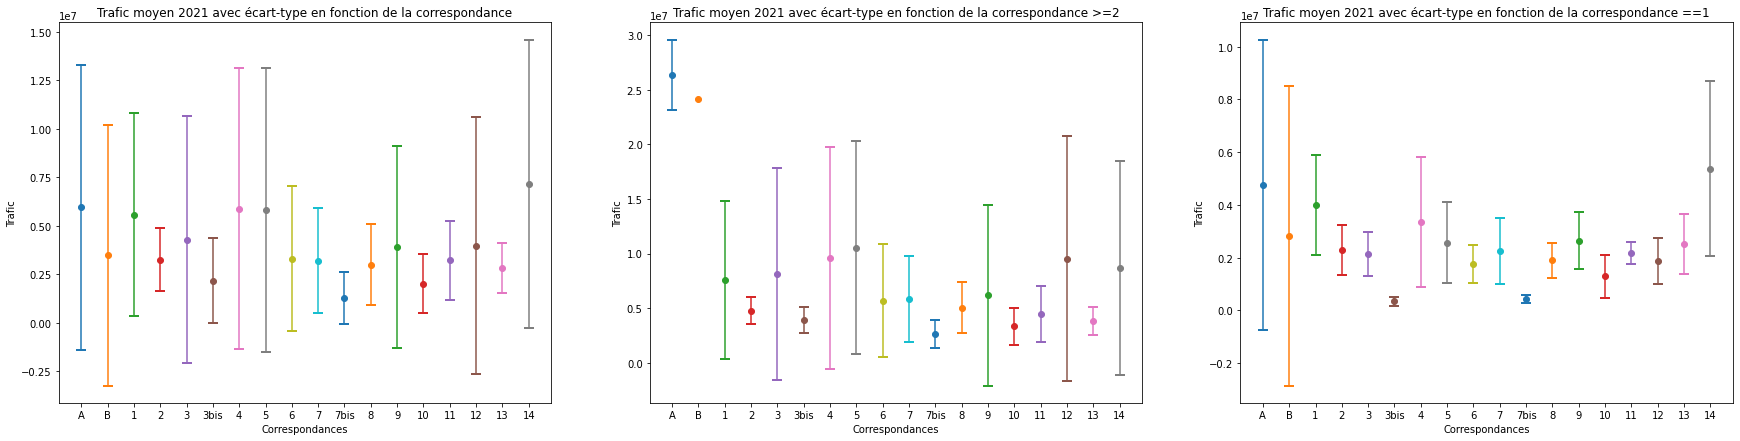

In [ ]:
df_plot = data_set_par_annee[2021][liste_ligne +['Trafic','nb_correspondances']]

# Cr√©ation de la figure avec 3 sous-graphiques dispos√©s sur une ligne
fig, axs = plt.subplots(1, 3, figsize=(30, 7))

# Premier graphique
for i, x in enumerate(x_values):
    y = df_plot[df_plot[liste_ligne[i]] != False]['Trafic']
    y_mean = statistics.mean(y)
    y_stdev = statistics.stdev(y)
    axs[0].errorbar(x, y_mean, yerr=y_stdev, fmt='o', capsize=5, capthick=2)
axs[0].set_xticks(x_values)
axs[0].set_xticklabels(liste_ligne)
axs[0].set_xlabel("Correspondances")
axs[0].set_ylabel("Trafic")
axs[0].set_title("Trafic moyen 2021 avec √©cart-type en fonction de la correspondance")

# Deuxi√®me graphique
for i, x in enumerate(x_values):
    y = df_plot[(df_plot[liste_ligne[i]] != False) & (df_plot['nb_correspondances'] >=2)]['Trafic']
    y_mean = statistics.mean(y)
    if len(y) >= 2:
        y_stdev = statistics.stdev(y)
    else:
        y_stdev = None
    axs[1].errorbar(x, y_mean, yerr=y_stdev, fmt='o', capsize=5, capthick=2)
axs[1].set_xticks(x_values)
axs[1].set_xticklabels(liste_ligne)
axs[1].set_xlabel("Correspondances")
axs[1].set_ylabel("Trafic")
axs[1].set_title("Trafic moyen 2021 avec √©cart-type en fonction de la correspondance >=2")

# Troisi√®me graphique
for i, x in enumerate(x_values):
    y = df_plot[(df_plot[liste_ligne[i]] != False) & (df_plot['nb_correspondances'] ==1)]['Trafic']
    y_mean = statistics.mean(y)
    if len(y) >= 2:
        y_stdev = statistics.stdev(y)
    else:
        y_stdev = None
    axs[2].errorbar(x, y_mean, yerr=y_stdev, fmt='o', capsize=5, capthick=2)
axs[2].set_xticks(x_values)
axs[2].set_xticklabels(liste_ligne)
axs[2].set_xlabel("Correspondances")
axs[2].set_ylabel("Trafic")
axs[2].set_title("Trafic moyen 2021 avec √©cart-type en fonction de la correspondance ==1")
plt.show()

On peut observer plusieurs choses :
- Les stations √† correspondances multiples sont plus utilis√©es que les isol√©es
- Les correspondances multiples avec les rer A et B ont un trafic signicativement sup√©rieur aux autres correspondances multiples
- Certaines stations de RER A et B isol√©es sont moins utilis√©es que les stations de m√©tros isol√©es
- Le m√©tro 14 semble largement plus utilis√© sur l'int√©gralit√© de sa ligne (en comparaison des autres lignes), il ne poss√®de pas de station avec un trafic faible. (cela peut s'expliquer en partie par son plus faible nombre de station)
- Les lignes 2, 3bis, 7bis, 10, 11 et 13 sont largement moins utilis√©es que les autres lignes.
- Les plus gros √©cart de trafic observable sur une m√™me ligne sont les rer A et B et les m√©tros 4, 5, 12 et 14. De plus ce sont ces m√™mes lignes qui g√©n√®re le plus de trafic au total (en comparrant avec les graphiques pr√©c√©dants)

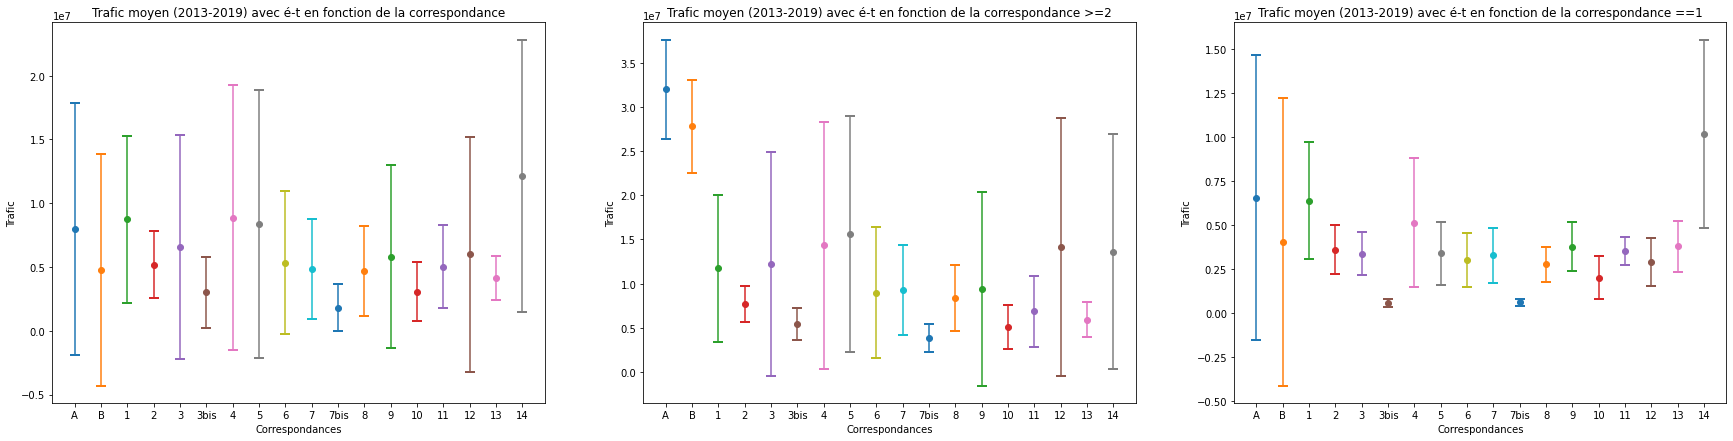

In [ ]:
df_plot = dataset_hors_covid[liste_ligne + ['Trafic','nb_correspondances']]

# Cr√©ation de la figure avec 3 sous-graphiques dispos√©s sur une ligne
fig, axs = plt.subplots(1, 3, figsize=(30, 7))

# Premier graphique
for i, x in enumerate(x_values):
    y = df_plot[df_plot[liste_ligne[i]] != False]['Trafic']
    y_mean = statistics.mean(y)
    y_stdev = statistics.stdev(y)
    axs[0].errorbar(x, y_mean, yerr=y_stdev, fmt='o', capsize=5, capthick=2)
axs[0].set_xticks(x_values)
axs[0].set_xticklabels(liste_ligne)
axs[0].set_xlabel("Correspondances")
axs[0].set_ylabel("Trafic")
axs[0].set_title("Trafic moyen (2013-2019) avec √©-t en fonction de la correspondance")

# Deuxi√®me graphique
for i, x in enumerate(x_values):
    y = df_plot[(df_plot[liste_ligne[i]] != False) & (df_plot['nb_correspondances'] >=2)]['Trafic']
    y_mean = statistics.mean(y)
    if len(y) >= 2:
        y_stdev = statistics.stdev(y)
    else:
        y_stdev = None
    axs[1].errorbar(x, y_mean, yerr=y_stdev, fmt='o', capsize=5, capthick=2)
axs[1].set_xticks(x_values)
axs[1].set_xticklabels(liste_ligne)
axs[1].set_xlabel("Correspondances")
axs[1].set_ylabel("Trafic")
axs[1].set_title("Trafic moyen (2013-2019) avec √©-t en fonction de la correspondance >=2")

# Troisi√®me graphique
for i, x in enumerate(x_values):
    y = df_plot[(df_plot[liste_ligne[i]] != False) & (df_plot['nb_correspondances'] ==1)]['Trafic']
    y_mean = statistics.mean(y)
    if len(y) >= 2:
        y_stdev = statistics.stdev(y)
    else:
        y_stdev = None
    axs[2].errorbar(x, y_mean, yerr=y_stdev, fmt='o', capsize=5, capthick=2)
axs[2].set_xticks(x_values)
axs[2].set_xticklabels(liste_ligne)
axs[2].set_xlabel("Correspondances")
axs[2].set_ylabel("Trafic")
axs[2].set_title("Trafic moyen (2013-2019) avec √©-t en fonction de la correspondance ==1")
plt.show()

A part une baisse du trafic global, le covid ne semble pas avoir affect√© les dynamyques sur les diff√©rentes lignes. Les observations faites sur 2021 sont aussi valable au global.

**Conclusion :**
- Le covid a affect√© le trafic au global (√† savoir le trafic total et individuel par station) mais pas les dynamiques (les parts du traffic par stations sont rest√© sensiblement les m√™me)
- Les lignes g√©n√©rant le plus de traffic sont celles qui ont aussi le plus de disparit√© de trafic par station
- 2, 3bis, 7bis, 10, 11 et 13 sont largement moins utilis√©es que les autres lignes.

# Rajout de donn√©es d√©mographique

Maintenant qu'on a explor√© les donn√©es de la RATP de mani√®re brut, j'aimerais y ajouter des informations d√©mographiques pour chaque ville.

Je vais rajouter 5 colonnes :
- La population totale de la ville 
- Le salaire net horaire moyen dans la ville
- La distance au centre de Paris
- La superficie de la ville
- Le nombre de station dans la ville

Pour cela j'ai cr√©√© deux fichiers .csv regrouppant ces informations depuis les sources suivantes (un pour les villes et un pour les arrondisements) :

- La population totale des villes vient du Recensement de la population de l'INSEE de 2020 (https://www.insee.fr/fr/statistiques/6683035?sommaire=6683037).
- Le salaire net moyen horaire par ville de l'√©tude de l'INSEE de 2020 sur les salaires net horaire moyen (https://www.insee.fr/fr/statistiques/2021266).
- La distance des villes au centre de Paris a √©t√© obtenu gr√¢ce √† des mesures manuelles sur Google map
- La superficie des villes a √©t√© obtenue via la superficie indiqu√©e sur Wikipedia (en km¬≤)
- Le nombre de station dans la ville est calcul√© √† partir des stations dans les donn√©es de la RATP (ie. les datasets de ce projet)


Cette √©tape de cr√©ation de csv √©tant r√©alis√©, je vais maintenant rajouter mes donn√©es √† mes dataframes existant :

In [ ]:
import csv

ville_dict = {}

with open('Donnees_villes.csv') as csv_file:
  reader = csv.reader(csv_file, delimiter=';')
  # Ignore la premi√®re ligne (en-t√™tes de colonnes)
  next(reader)
  for row in reader:
    # R√©cup√©rer le nom de la ville et enlever les espaces inutiles
    ville = row[0].strip()
    # Ajouter la ville au dictionnaire avec les autres informations comme valeur
    ville_dict[ville] = {
      'Population': int(row[1]),
      'Salaire net horaire moyen': float(row[2]),
      'Distance de Paris': float(row[3]),
      'Superficie': float(row[4])
    }

print(ville_dict)


arrondissements_dict = {}

with open('Donnees_arrondissements.csv') as csv_file:
  reader = csv.reader(csv_file, delimiter=';')
  # Ignore la premi√®re ligne (en-t√™tes de colonnes)
  next(reader)
  for row in reader:
    # R√©cup√©rer le nom de l'arrondissement et enlever les espaces inutiles
    arrondissement = row[0].strip()
    # Ajouter l'arrondissement au dictionnaire avec les autres informations comme valeur
    arrondissements_dict[arrondissement] = {
      'Population': int(row[1]),
      'Salaire net horaire moyen': float(row[2]),
      'Distance de Paris': float(row[3]),
      'Superficie': float(row[4])
    }

print(arrondissements_dict)

{'Antony': {'Population': 63319, 'Salaire net horaire moyen': 24.64, 'Distance de Paris': 12.44, 'Superficie': 9.56}, 'Asnieres sur Seine': {'Population': 68987, 'Salaire net horaire moyen': 23.99, 'Distance de Paris': 7.32, 'Superficie': 4.82}, 'Aubervilliers': {'Population': 86597, 'Salaire net horaire moyen': 12.38, 'Distance de Paris': 6.57, 'Superficie': 5.76}, 'Bagnolet': {'Population': 35797, 'Salaire net horaire moyen': 15.55, 'Distance de Paris': 5.86, 'Superficie': 2.57}, 'Bobigny': {'Population': 53814, 'Salaire net horaire moyen': 12.17, 'Distance de Paris': 8.85, 'Superficie': 6.77}, 'Boissy-Saint-L√©ger': {'Population': 16426, 'Salaire net horaire moyen': 15.19, 'Distance de Paris': 16.96, 'Superficie': 8.94}, 'Boulogne Billancourt': {'Population': 145159, 'Salaire net horaire moyen': 30.48, 'Distance de Paris': 7.93, 'Superficie': 6.17}, 'Bourg la Reine': {'Population': 21009, 'Salaire net horaire moyen': 26.15, 'Distance de Paris': 8.88, 'Superficie': 1.87}, 'Bry-sur-Ma

In [ ]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import unidecode

#Fonction qui permet de comparer 2 string sans prendre en compte les accents et les tirets/espaces
def compare_strings(s1: str, s2: str) -> bool:
    # Suppression des accents et transformation en minuscule
    s1 = unidecode.unidecode(s1).lower()
    s2 = unidecode.unidecode(s2).lower()
    # Suppression des espaces et tirets
    s1 = s1.replace(" ", "").replace("-", "")
    s2 = s2.replace(" ", "").replace("-", "")
    # Comparaison des cha√Ænes
    return s1 == s2

for annee in range(2013,2022) :
  nb_stations_par_ville = {}
  nb_stations_par_arrondisement = {}
  #Permet de compter le nombre de station par ville
  for ville in data_set_par_annee[annee]['Ville']:
    if ville not in nb_stations_par_ville:
        nb_stations_par_ville[ville] = 1
    else:
        nb_stations_par_ville[ville] += 1
  #Permet de compter le nombre de station par arrondissement
  for arrondissement in data_set_par_annee[annee]['Arrondissement pour Paris']:
    if arrondissement > 0 :
      if arrondissement not in nb_stations_par_arrondisement:
        nb_stations_par_arrondisement[arrondissement] = 1
      else:
        nb_stations_par_arrondisement[arrondissement] += 1
  #Initialise chaque nouvelle colonne
  data_set_par_annee[annee]['Superficie']=0.0
  data_set_par_annee[annee]['Salaire_moyen']=0.0
  data_set_par_annee[annee]['Distance_paris']=0.0
  data_set_par_annee[annee]['Population']=0
  data_set_par_annee[annee]['Nb_station_ville_ou_arrondissement']=0
  #On va naviguer sur chacune des ligne du dataframe pour y ajouter les √©l√©mments correspondants
  for station_id in range(len(data_set_par_annee[annee])):
    if (compare_strings(data_set_par_annee[annee]['Ville'][station_id],"Paris")) :
      for arrondissement, data in arrondissements_dict.items() :
        if (float(arrondissement)==float(data_set_par_annee[annee]['Arrondissement pour Paris'][station_id])) :
          data_set_par_annee[annee].loc[station_id, 'Superficie'] = data["Superficie"]
          data_set_par_annee[annee].loc[station_id, 'Salaire_moyen'] = data["Salaire net horaire moyen"]
          data_set_par_annee[annee].loc[station_id, 'Distance_paris'] = data["Distance de Paris"]
          data_set_par_annee[annee].loc[station_id, 'Population'] = data["Population"]
          data_set_par_annee[annee].loc[station_id, 'Nb_station_ville_ou_arrondissement'] = nb_stations_par_arrondisement[data_set_par_annee[annee]['Arrondissement pour Paris'][station_id]]
    else :
      for ville, data in ville_dict.items() :
        if (compare_strings(data_set_par_annee[annee]['Ville'][station_id],ville)):
          data_set_par_annee[annee].loc[station_id, 'Superficie'] = data["Superficie"]
          data_set_par_annee[annee].loc[station_id, 'Salaire_moyen'] = data["Salaire net horaire moyen"]
          data_set_par_annee[annee].loc[station_id, 'Distance_paris'] = data["Distance de Paris"]
          data_set_par_annee[annee].loc[station_id, 'Population'] = data["Population"]
          data_set_par_annee[annee].loc[station_id, 'Nb_station_ville_ou_arrondissement'] = nb_stations_par_ville[data_set_par_annee[annee]['Ville'][station_id]]

In [ ]:
print(data_set_par_annee[2014][(data_set_par_annee[2014]["Superficie"]==0)]["Station"])

Series([], Name: Station, dtype: object)


Remarque : c'est ici que je me suis aper√ßu qu'il manquait des arrondissement dans le fichier csv de 2014

Je v√©rifie que tout est bien pass√© (i.e. valeur √† 0 ou incoh√©rente)

In [ ]:
pd.options.display.max_rows = len(data_set_par_annee[2020])
for annee in range(2013,2022) :
  print(data_set_par_annee[annee][(data_set_par_annee[annee]["Distance_paris"]==0.0)])

Empty DataFrame
Columns: [Rang, R√©seau, Station, Trafic, Ville, Arrondissement pour Paris, A, B, 1, 2, 3, 3bis, 4, 5, 6, 7, 7bis, 8, 9, 10, 11, 12, 13, 14, nb_correspondances, Ann√©e, Superficie, Salaire_moyen, Distance_paris, Population, Nb_station_ville_ou_arrondissement]
Index: []

[0 rows x 31 columns]
Empty DataFrame
Columns: [Rang, R√©seau, Station, Trafic, Ville, Arrondissement pour Paris, A, B, 1, 2, 3, 3bis, 4, 5, 6, 7, 7bis, 8, 9, 10, 11, 12, 13, 14, nb_correspondances, Ann√©e, Superficie, Salaire_moyen, Distance_paris, Population, Nb_station_ville_ou_arrondissement]
Index: []

[0 rows x 31 columns]
Empty DataFrame
Columns: [Rang, R√©seau, Station, Trafic, Ville, Arrondissement pour Paris, A, B, 1, 2, 3, 3bis, 4, 5, 6, 7, 7bis, 8, 9, 10, 11, 12, 13, 14, nb_correspondances, Ann√©e, Superficie, Salaire_moyen, Distance_paris, Population, Nb_station_ville_ou_arrondissement]
Index: []

[0 rows x 31 columns]
Empty DataFrame
Columns: [Rang, R√©seau, Station, Trafic, Ville, Arrondis

In [ ]:
# Initialisation de la liste des dataframes √† concat√©ner
df_list = []

# Ajout de chaque dataframe √† la liste
for annee in range(2013, 2022):
    df_list.append(data_set_par_annee[annee])

# Concat√©nation des dataframes
dataset_complet = pd.concat(df_list, axis=0)

In [ ]:
dataset_complet

Rang R√©seau             Station    Trafic               Ville  \
0      12  M√©tro               OPERA  12269711               Paris   
1      19  M√©tro              NATION   9541406               Paris   
2      20  M√©tro        PALAIS-ROYAL   9385220               Paris   
3      39  M√©tro   GRANDS BOULEVARDS   7092775               Paris   
4      41  M√©tro    MAIRIE DE CLICHY   6987958              Clichy   
..    ...    ...                 ...       ...                 ...   
366    39    RER  FONTENAY-SOUS-BOIS   2121720  Fontenay-sous-Bois   
367    40    RER       SUCY-BONNEUIL   1993503        Sucy-en-Brie   
368    58    RER          LE GUICHET    530706               Orsay   
369    65    RER      PARC DE SCEAUX    383626              Antony   
370    66    RER      LA HACQUINIERE    285626    Bures sur Yvette   

     Arrondissement pour Paris      A      B      1      2  ...     12     13  \
0                          9.0  False  False  False  False  ...  False  False   
1                         12.0  False  False   True   True  ...  False  False   
2                          1.0  False  False   True  False  ...  False  False   
3                          9.0  False  False  False  False  ...  False  False   
4                          NaN  False  False  False  False  ...  False   True   
..                         ...    ...    ...    ...    ...  ...    ...    ...   
366                        NaN   True  False  False  False  ...  False  False   
367                        NaN   True  False  False  False  ...  False  False   
368                        NaN  False   True  False  False  ...  False  False   
369                        NaN  False   True  False  False  ...  False  False   
370                        NaN  False   True  False  False  ...  False  False   

        14  nb_correspondances  Ann√©e  Superficie  Salaire_moyen  \
0    False                   3   2013        2.18          32.53   
1    False                   3   2013       16.32          23.19   
2    False                   2   2013        1.83          31.07   
3    False                   2   2013        2.18          32.53   
4    False                   1   2013        5.08          20.54   
..     ...                 ...    ...         ...            ...   
366  False                   1   2021        5.58          21.35   
367  False                   1   2021       10.43          20.16   
368  False                   1   2021        7.97          24.59   
369  False                   1   2021        9.56          24.64   
370  False                   1   2021        4.17          24.84   

     Distance_paris  Population  Nb_station_ville_ou_arrondissement  
0              2.69       60071                                  14  
1              6.21      141287                                  21  
2              1.50       16395                                   8  
3              2.69       60071                                  14  
4              5.62       61070                                   1  
..              ...         ...                                 ...  
366            9.66       53418                                   2  
367           16.79       26709                                   1  
368           20.91       16753                                   2  
369           12.44       63319                                   5  
370           22.92        9997                                   2  

[3325 rows x 31 columns]

In [ ]:
data_set_par_annee[2021].head()

Rang R√©seau               Station    Trafic        Ville  \
0     3  M√©tro          GARE DE LYON  28640475        Paris   
1    12  M√©tro            BELLEVILLE   7314438        Paris   
2    32  M√©tro                 OPERA   5193831        Paris   
3    58  M√©tro  SAINT-MANDE-TOURELLE   3944640  Saint Mand√©   
4    59  M√©tro                 HOCHE   3928404       Pantin   

   Arrondissement pour Paris      A      B      1      2  ...     12     13  \
0                       12.0   True  False   True  False  ...  False  False   
1                       10.0  False  False  False   True  ...  False  False   
2                        9.0  False  False  False  False  ...  False  False   
3                        NaN  False  False   True  False  ...  False  False   
4                        NaN  False  False  False  False  ...  False  False   

      14  nb_correspondances  Ann√©e  Superficie  Salaire_moyen  \
0   True                   3   2021       16.32          23.19   
1  False                   2   2021        2.89          24.66   
2  False                   3   2021        2.18          32.53   
3  False                   1   2021        0.92          28.10   
4  False                   1   2021        5.01          15.94   

   Distance_paris  Population  Nb_station_ville_ou_arrondissement  
0            6.21      141287                                  21  
1            2.51       90836                                  11  
2            2.69       60071                                  14  
3            5.81       22835                                   1  
4            6.47       57668                                   3  

[5 rows x 31 columns]

Les donn√©es d√©mographiques ont √©t√© ajout√©es avec succ√®s. Maintenant place √† leur exploration üòé !

# Exploration de ces nouvelles donn√©es

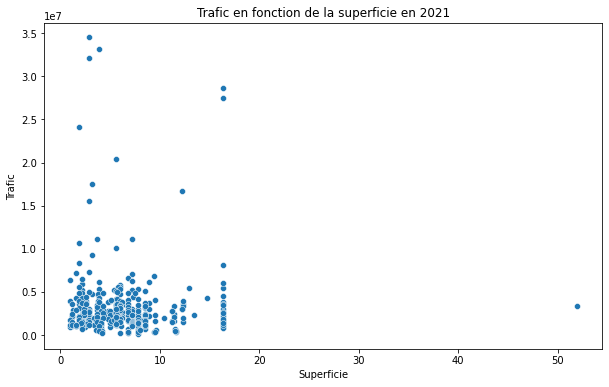

In [ ]:
df_plot = data_set_par_annee[2021][['Superficie', 'Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Superficie', y='Trafic', data=df_plot)
plt.title("Trafic en fonction de la superficie en 2021")
plt.show()

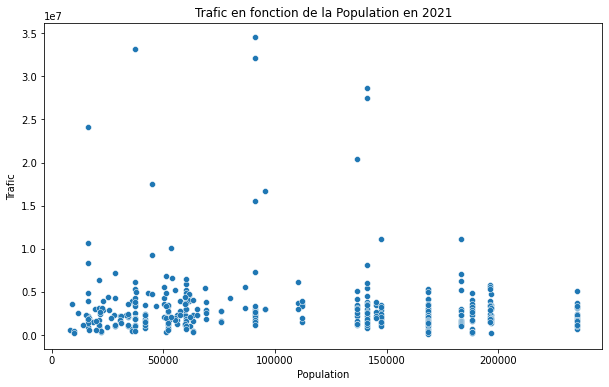

In [ ]:
df_plot = data_set_par_annee[2021][['Population', 'Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Population', y='Trafic', data=df_plot)
plt.title("Trafic en fonction de la Population en 2021")
plt.show()

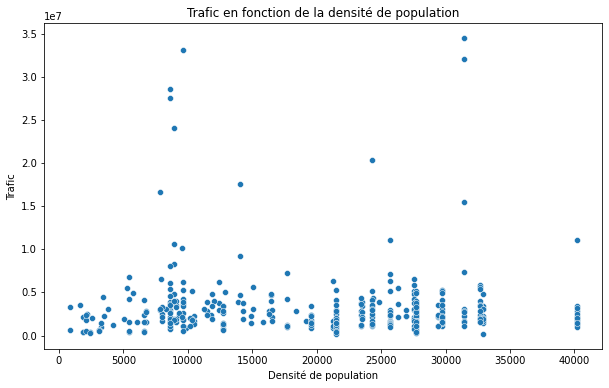

In [ ]:
df_plot = data_set_par_annee[2021][['Population', 'Superficie', 'Trafic']]
df_plot = df_plot.dropna()
df_plot.at[:, 'Densit√© de population'] = df_plot['Population'] / df_plot['Superficie']
plt.figure(figsize=(10,6))
sns.scatterplot(x='Densit√© de population', y='Trafic', data=df_plot)
plt.xlabel('Densit√© de population')
plt.ylabel('Trafic')
plt.title('Trafic en fonction de la densit√© de population')
plt.show()

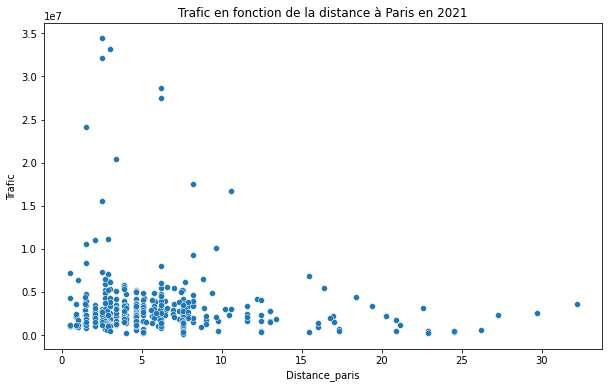

In [ ]:
df_plot = data_set_par_annee[2021][['Distance_paris','Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Distance_paris', y='Trafic', data=df_plot)
plt.title("Trafic en fonction de la distance √† Paris en 2021")
plt.show()

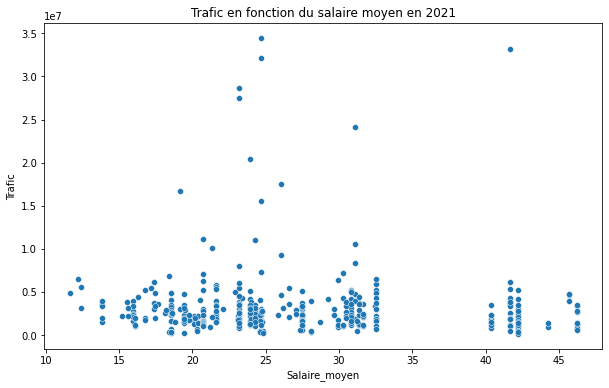

In [ ]:
df_plot = data_set_par_annee[2021][['Salaire_moyen','Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Salaire_moyen', y='Trafic', data=df_plot)
plt.title("Trafic en fonction du salaire moyen en 2021")
plt.show()

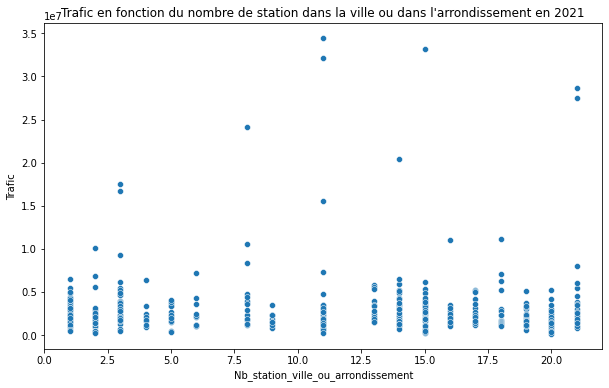

In [ ]:
df_plot = data_set_par_annee[2021][['Nb_station_ville_ou_arrondissement','Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Nb_station_ville_ou_arrondissement', y='Trafic', data=df_plot)
plt.title("Trafic en fonction du nombre de station dans la ville ou dans l'arrondissement en 2021")
plt.show()

In [ ]:
data_set_par_annee[2021].dtypes

Rang                                    int64
R√©seau                                 object
Station                                object
Trafic                                  int64
Ville                                  object
Arrondissement pour Paris             float64
A                                        bool
B                                        bool
1                                        bool
2                                        bool
3                                        bool
3bis                                     bool
4                                        bool
5                                        bool
6                                        bool
7                                        bool
7bis                                     bool
8                                        bool
9                                        bool
10                                       bool
11                                       bool
12                               

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# S√©lectionnez des colonnes √† utiliser comme features
features = data_set_par_annee[2021].drop(columns=['Ville','Trafic','Arrondissement pour Paris','Rang','Station','R√©seau'])

# S√©lection la colonne cible ('Trafic')
target = data_set_par_annee[2021]['Trafic']

# S√©paration de mes donn√©es d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


R√©gression lin√©aire :

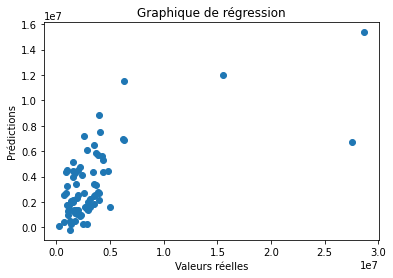

MSE =11810732221995.96
R2 =0.4305563218987395
MAE =1932223.6787914212


In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs r√©elles')
plt.ylabel('Pr√©dictions')
plt.title('Graphique de r√©gression')
plt.show()

print ("MSE ="+ str(mse))
print ("R2 ="+ str(r2))
print ("MAE ="+ str(mae))

Le mod√®le lin√©aire n'est pas bon du tout (sans trop de surprise). Je vais tester d'autres mod√®les.

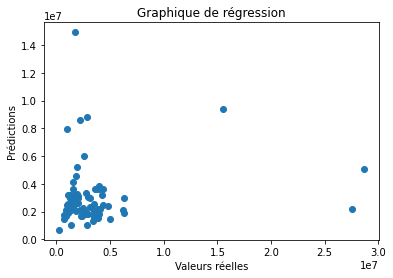

MSE =23071482206615.523
R2 =-0.11237046442516663
MAE =2414038.3200000003


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

# Entra√Æner le mod√®le sur le jeu de donn√©es d'entra√Ænement
knn.fit(X_train, y_train)

# Pr√©dire sur l'√©chantillon de test
y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs r√©elles')
plt.ylabel('Pr√©dictions')
plt.title('Graphique de r√©gression')
plt.show()

print ("MSE ="+ str(mse))
print ("R2 ="+ str(r2))
print ("MAE ="+ str(mae))

In [ ]:
import tensorflow as tf

# S√©lectionnez des colonnes √† utiliser comme features
features = data_set_par_annee[2021].drop(columns=['Ville','Trafic','Arrondissement pour Paris','Rang','Station','R√©seau']+liste_ligne)

# S√©lection la colonne cible ('Trafic')
target = data_set_par_annee[2021]['Trafic']

# S√©paration de mes donn√©es d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


# Convertissez les donn√©es en tenseurs
X_train_tensor = tf.convert_to_tensor(X_train)
y_train_tensor = tf.convert_to_tensor(y_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_test_tensor = tf.convert_to_tensor(y_test)


# Cr√©ez un mod√®le de r√©seau de neurones
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[X_train_tensor.shape[1]]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compilez le mod√®le
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss=tf.keras.losses.MeanSquaredError())

# Entra√Ænez le mod√®le
model.fit(X_train_tensor, y_train_tensor, epochs=10, verbose=2)

# √âvaluez le mod√®le sur le jeu de test
results = model.evaluate(X_test_tensor, y_test_tensor,batch_size=128)
print(results)


Epoch 1/10
10/10 - 1s - loss: 26961569120256.0000 - 943ms/epoch - 94ms/step
Epoch 2/10
10/10 - 0s - loss: 26782401036288.0000 - 19ms/epoch - 2ms/step
Epoch 3/10
10/10 - 0s - loss: 26622895849472.0000 - 21ms/epoch - 2ms/step
Epoch 4/10
10/10 - 0s - loss: 26451795509248.0000 - 23ms/epoch - 2ms/step
Epoch 5/10
10/10 - 0s - loss: 26269875961856.0000 - 21ms/epoch - 2ms/step
Epoch 6/10
10/10 - 0s - loss: 26064178905088.0000 - 29ms/epoch - 3ms/step
Epoch 7/10
10/10 - 0s - loss: 25837793443840.0000 - 33ms/epoch - 3ms/step
Epoch 8/10
10/10 - 0s - loss: 25594555269120.0000 - 26ms/epoch - 3ms/step
Epoch 9/10
10/10 - 0s - loss: 25337131958272.0000 - 21ms/epoch - 2ms/step
Epoch 10/10
10/10 - 0s - loss: 25045806088192.0000 - 22ms/epoch - 2ms/step
1/1 [==============================] - 0s 124ms/step - loss: 29886706089984.0000
29886706089984.0


# Test en excluant les stations √† multiple correspondances

In [ ]:
df_sans_multiple_correspondance=data_set_par_annee[2021][(data_set_par_annee[2021]['nb_correspondances'] == 1)]

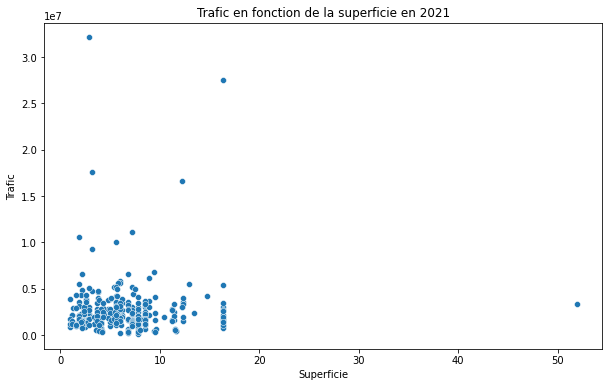

In [ ]:
df_plot = df_sans_multiple_correspondance[['Superficie', 'Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Superficie', y='Trafic', data=df_plot)
plt.title("Trafic en fonction de la superficie en 2021")
plt.show()

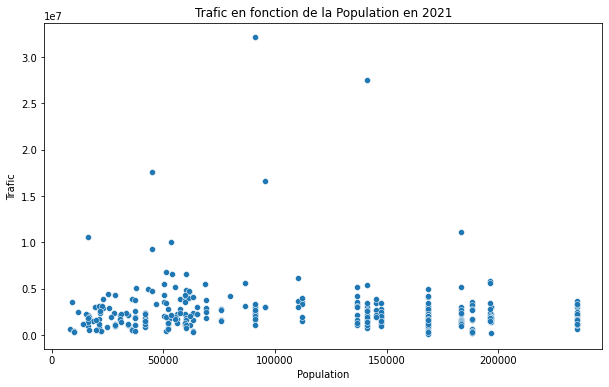

In [ ]:
df_plot = df_sans_multiple_correspondance[['Population', 'Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Population', y='Trafic', data=df_plot)
plt.title("Trafic en fonction de la Population en 2021")
plt.show()

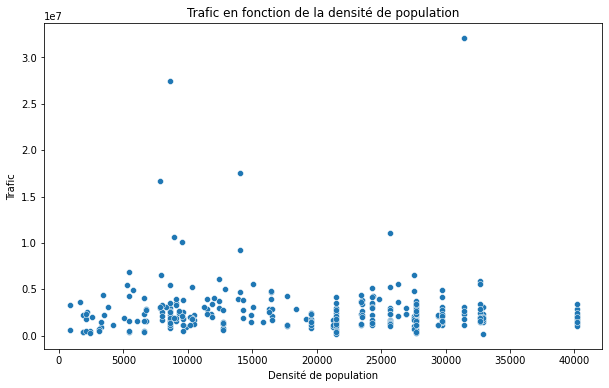

In [ ]:
df_plot = df_sans_multiple_correspondance[['Population', 'Superficie', 'Trafic']]
df_plot = df_plot.dropna()
df_plot.at[:, 'Densit√© de population'] = df_plot['Population'] / df_plot['Superficie']
plt.figure(figsize=(10,6))
sns.scatterplot(x='Densit√© de population', y='Trafic', data=df_plot)
plt.xlabel('Densit√© de population')
plt.ylabel('Trafic')
plt.title('Trafic en fonction de la densit√© de population')
plt.show()

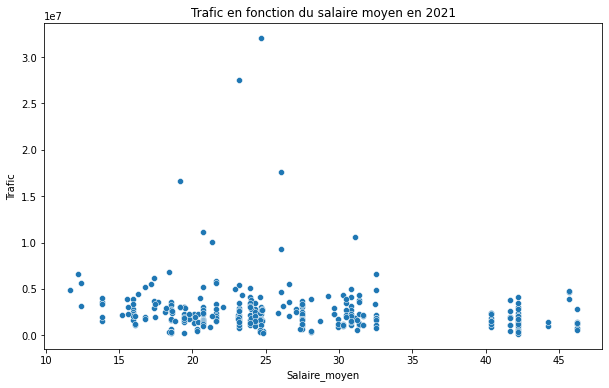

In [ ]:
df_plot = df_sans_multiple_correspondance[['Salaire_moyen','Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Salaire_moyen', y='Trafic', data=df_plot)
plt.title("Trafic en fonction du salaire moyen en 2021")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# S√©lectionnez des colonnes √† utiliser comme features
features = df_sans_multiple_correspondance.drop(columns=['Ville','Trafic','Arrondissement pour Paris','Rang','Station','R√©seau'])

# S√©lection la colonne cible ('Trafic')
target = df_sans_multiple_correspondance['Trafic']

# S√©paration de mes donn√©es d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

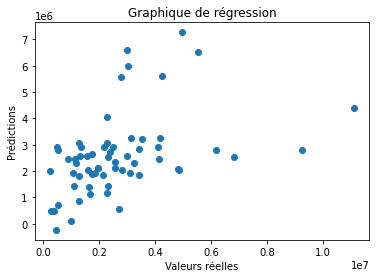

MSE =3614611883754.5244
R2 =0.09948808398869391
MAE =1331807.1041262867


In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs r√©elles')
plt.ylabel('Pr√©dictions')
plt.title('Graphique de r√©gression')
plt.show()

print ("MSE ="+ str(mse))
print ("R2 ="+ str(r2))
print ("MAE ="+ str(mae))

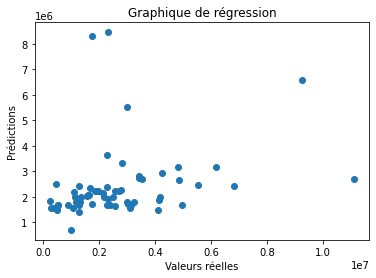

MSE =4437448924486.306
R2 =-0.10550614054884999
MAE =1408222.3322580645


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

# Entra√Æner le mod√®le sur le jeu de donn√©es d'entra√Ænement
knn.fit(X_train, y_train)

# Pr√©dire sur l'√©chantillon de test
y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs r√©elles')
plt.ylabel('Pr√©dictions')
plt.title('Graphique de r√©gression')
plt.show()

print ("MSE ="+ str(mse))
print ("R2 ="+ str(r2))
print ("MAE ="+ str(mae))

In [ ]:
import tensorflow as tf

# S√©lectionnez des colonnes √† utiliser comme features
features = df_sans_multiple_correspondance.drop(columns=['Ville','Trafic','Arrondissement pour Paris','Rang','Station','R√©seau']+liste_ligne)

# S√©lection la colonne cible ('Trafic')
target = df_sans_multiple_correspondance['Trafic']

# S√©paration de mes donn√©es d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


# Convertissez les donn√©es en tenseurs
X_train_tensor = tf.convert_to_tensor(X_train)
y_train_tensor = tf.convert_to_tensor(y_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_test_tensor = tf.convert_to_tensor(y_test)


# Cr√©ez un mod√®le de r√©seau de neurones
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[X_train_tensor.shape[1]]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compilez le mod√®le
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss=tf.keras.losses.MeanSquaredError())

# Entra√Ænez le mod√®le
model.fit(X_train_tensor, y_train_tensor, epochs=10, verbose=2)

# √âvaluez le mod√®le sur le jeu de test
results = model.evaluate(X_test_tensor, y_test_tensor,batch_size=128)
print(results)

Epoch 1/10
8/8 - 1s - loss: 16633864126464.0000 - 936ms/epoch - 117ms/step
Epoch 2/10
8/8 - 0s - loss: 16463114010624.0000 - 17ms/epoch - 2ms/step
Epoch 3/10
8/8 - 0s - loss: 16319891111936.0000 - 20ms/epoch - 3ms/step
Epoch 4/10
8/8 - 0s - loss: 16182933454848.0000 - 20ms/epoch - 3ms/step
Epoch 5/10
8/8 - 0s - loss: 16046783201280.0000 - 20ms/epoch - 3ms/step
Epoch 6/10
8/8 - 0s - loss: 15901379264512.0000 - 24ms/epoch - 3ms/step
Epoch 7/10
8/8 - 0s - loss: 15748087939072.0000 - 17ms/epoch - 2ms/step
Epoch 8/10
8/8 - 0s - loss: 15581420978176.0000 - 20ms/epoch - 3ms/step
Epoch 9/10
8/8 - 0s - loss: 15409559371776.0000 - 21ms/epoch - 3ms/step
Epoch 10/10
8/8 - 0s - loss: 15232871170048.0000 - 19ms/epoch - 2ms/step
1/1 [==============================] - 0s 151ms/step - loss: 9226232528896.0000
9226232528896.0


Pour l'instant, je n'obtiens pas de mod√®lation ad√©quate mais je continue mes exp√©rimentations.